/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['CMU Sans Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


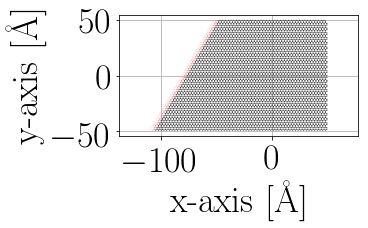

In [50]:
from math import pi, sqrt, tanh
import kwant
from matplotlib import pyplot
import numpy as np
from functools import partial
import copy
%matplotlib inline
font = {'family' : 'CMU Sans Serif',
#         'weight' : 'light',
        'size'   : 36}

pyplot.rc('font', **font)
pyplot.rc('text', usetex=True)


# function to rotate 2D vectors
def rot(vec, theta):
    rot_mat = np.array([ [np.cos(-theta), -np.sin(-theta)], [np.sin(-theta), np.cos(-theta)] ])
    return rot_mat.dot(vec)

# function to find a vector orthogonal to the passed vector
def orthogVecSlope(vec):
    A = np.array([[vec[0], vec[1]], [-vec[1], vec[0]]])
    trans_vec = np.linalg.solve(A, np.array([0., 1.]))
    if trans_vec[0] == 0.:
        a = 0.
    else:
        a = trans_vec[1] / trans_vec[0]
    return a

# lattice constant
a = 1.42
# hopping energy
t = 2.7
# on-site energy of 0 gives singular matrix
on_site = 0.0
# length of hexagon
l = 50.0
# ratio to define x-length of hexagon
ratio = sqrt(3) / 2
lx = l * ratio
# slope for defining hexagon
m = np.sin(np.pi / 6) / np.cos(np.pi / 6)



# if we want conducting (zigzag) leads or not, else semi-conducting (armchair) leads
conducting = 1

if conducting:
    # set lattice vectors and basis 
    v1 = np.array((a * sqrt(3) / 2., 3 * a / 2))
    v2 = np.array((-a * sqrt(3) / 2., 3 * a / 2))
    graphene = kwant.lattice.general([v1, v2], [(0, 0), (0, -a) ], norbs=1 )
else:
    v1 = np.array((3 * a / 2, a * sqrt(3) / 2.))
    v2 = np.array((3 * a / 2, -a * sqrt(3) / 2.))
    graphene = kwant.lattice.general([v1, v2], [(0, 0), (-a, 0) ], norbs=1 )
    
def make_system():

    # rectangular shape
    def shape(coord):
        x, y = coord
        if x > -l and x < l and y >= -50.5 and y < 50.5:
            return True
        else:
            return False
    # construct the nanojunction
    ############################
    syst = kwant.Builder()
    # set the on-site energies
    syst[graphene.shape(shape , (0, 0))] = on_site
    # set the hopping energies
    syst[graphene.neighbors()] =  -t
    # remove lone orbitals
    syst.eradicate_dangling()
    ############################
    
    # add the lead on the left hand side
    ####################################
    if conducting:
        sym = kwant.TranslationalSymmetry(graphene.vec((-1, 1)))
        lead = kwant.Builder(sym)
        a = orthogVecSlope(graphene.vec((-1,1)))
        lead[graphene.shape(shape, (0,0))] = on_site
        lead[graphene.neighbors()] = -t
        lead.eradicate_dangling()
        syst.attach_lead(lead)
    else:
        sym = kwant.TranslationalSymmetry(graphene.vec((-1, -1)))
        lead = kwant.Builder(sym)
        a = orthogVecSlope(graphene.vec((-1,-1)))
        lead[graphene.shape(shape, (0,0))] = on_site
        lead[graphene.neighbors()] = -t
        lead.eradicate_dangling()
        syst.attach_lead(lead)
        
        syst.attach_lead(lead.reversed())
    ####################################
    
    
    return syst

syst = make_system()

# To highlight the two sublattices of graphene, we plot one with
# a filled, and the other one with an open circle:
def family_colors(site):
    return 0 if site.family == a else 1

# Then, plot the system with leads.
kwant.plot(syst, site_lw=0.1, lead_site_lw=0, site_color=family_colors, colorbar=False, show=False)
pyplot.axis('equal')
pyplot.grid(True)
pyplot.ylabel('y-axis [\AA]')
pyplot.xlabel('x-axis [\AA]')
pyplot.savefig('graphene_nanoribbon.pdf')
pyplot.tight_layout()
pyplot.show()


# Finalize the system.
syst = syst.finalized()

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['CMU Sans Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


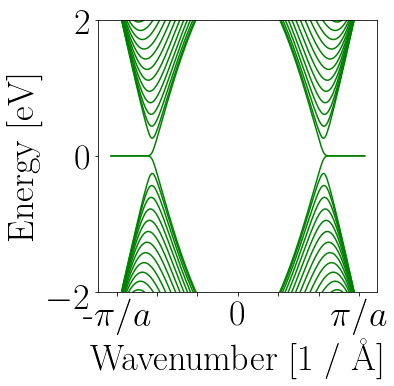

In [49]:
fig, axes = pyplot.subplots(1,1, figsize=(5,5), sharey='row')
momenta = np.linspace(-np.pi,  np.pi, 256)
bands0 = kwant.physics.Bands(syst.leads[0])
energies0 = [bands0(k) for k in momenta]
pyplot.plot(momenta, energies0, 'g')
# pyplot.xlim([-1.5, 1.5])
pyplot.ylim([-2, 2])
pyplot.xticks(range(-3,4), ['-$\pi / a$', '', '', 0, '', '', '$\pi / a$'])
pyplot.ylabel('Energy [eV]')
pyplot.xlabel('Wavenumber [1 / \AA]')
pyplot.savefig('1d_dispersion_relation_graphene.pdf')
pyplot.show()

In [37]:
# calculate the conductance using the smatrix function of kwant
def conductance(syst, energies, lead_start=0, lead_end=1):
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        data.append(smatrix.transmission(lead_start, lead_end))
    return data
    

energies, doss = [], []
for e in np.linspace(-10.0, 10.0, 256):
    # sometimes the ldos function returns an error for a certain value of energy
    # -- we therefore must use a try-except statement
    try:
        dos = kwant.ldos(syst, e)
        energies.append(e)
        # integrate the ldos over all space
        doss.append(np.sum(dos))
    except:
        pass

# calculate the two conductances for the two leads
e = np.linspace(-10,10,256)
cond1 = conductance(syst, energies=e)
cond2 = conductance(syst, energies=e, lead_end=2)

Total number of states: 13033.424226314557


Text(0.5,0,'Density of states [Arbitrary units]')

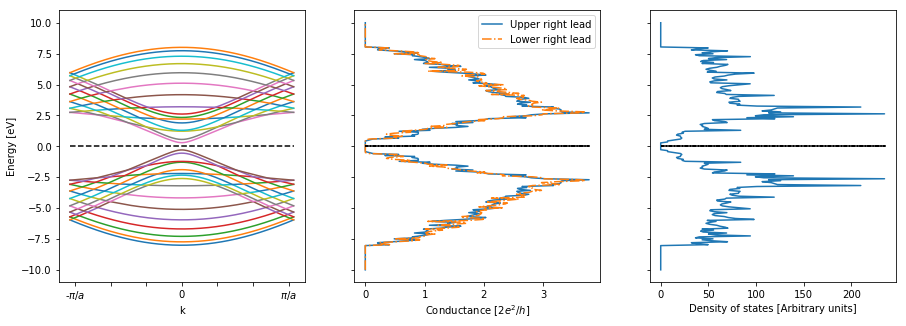

In [38]:
# plot the bandstructure, conductances, and DOS
fig, axes = pyplot.subplots(1,3, figsize=(15,5), sharey='row')
kwant.plotter.bands(syst.leads[0], momenta=np.linspace(-np.pi,  np.pi, 256), show=False, ax=axes[0])
axes[1].plot(cond1, e)
axes[1].plot(cond2, e, '-.')
axes[2].plot(doss, energies)

e_fermi = np.ones(256) * 0.01
axes[0].plot(np.linspace(-np.pi,  np.pi, 256), e_fermi, '--', color='k')
axes[1].plot(cond1, e_fermi, '--', color='k')
axes[2].plot(doss, np.ones_like(energies) * 0.01, '--', color='k')

print('Total number of states:', np.sum(doss))

axes[0].set_ylim((np.min(energies) -1, np.max(energies) + 1))
axes[1].set_ylim((np.min(energies) -1, np.max(energies) + 1))
axes[2].set_ylim((np.min(energies) -1, np.max(energies) + 1))
axes[0].set_xlabel('k')
axes[0].set_ylabel('Energy [eV]')
pyplot.sca(axes[0])
pyplot.xticks(range(-3,4), ['-$\pi / a$', '', '', 0, '', '', '$\pi / a$'])

axes[1].set_xlabel('Conductance [$2e^2 / h$]')
axes[1].legend(['Upper right lead','Lower right lead'])
axes[2].set_xlabel('Density of states [Arbitrary units]')

Text(0,0.5,'dI / dV [$2e^2 h^{-1} eV^{-1}$]')

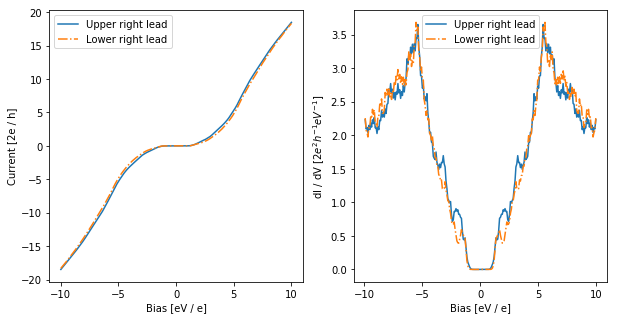

In [39]:
# define the temperature multiplied by the Boltzmann constant
kB_T = t / 100.
# the Fermi-Dirac distribution
def fermi(E, mu):
    return 1. / (np.exp((E - mu) / (kB_T)) + 1.)

# make the function vectorized
vec_fermi = np.vectorize(fermi)

# range of bias values
bias = np.linspace(-10.0, 10.0, 256)
db = bias[1] - bias[0]
# collect the current values in lists 
I_ur, I_lr = [], []
dI_ur, dI_lr = [], []

# loop over the bias values
for i, val in enumerate(bias):
    # make the chemical potential differences symmetric about the bias
    mu_left = val / 2.0 + on_site 
    mu_right = -val / 2.0 + on_site
    
    # difference in the Fermi-Dirac functions
    diff = vec_fermi(e, mu_left) - vec_fermi(e, mu_right)
    
    # multiply the conductances by the difference and integrate over the energy
    current1 = (e[1] - e[0]) * np.sum(cond1 * diff)
    current2 = (e[1] - e[0]) * np.sum(cond2 * diff)
    
    # append value to list
    I_ur.append(current1)
    I_lr.append(current2)
    
    if i > 0:
        dI_ur.append((current1 - I_ur[i - 1]) / db)
        dI_lr.append((current2 - I_lr[i - 1]) / db)

# plot the currents
fig, axes = pyplot.subplots(1, 2, figsize=(10,5))
axes[0].plot(bias, I_ur, bias, I_lr, '-.')
axes[0].legend(['Upper right lead', 'Lower right lead'])
axes[0].set_xlabel('Bias [eV / e]')
axes[0].set_ylabel('Current [2e / h]')
# plot the differential dI/dV
axes[1].plot(bias[1:], dI_ur, bias[1:], dI_lr, '-.')
axes[1].legend(['Upper right lead', 'Lower right lead'])
axes[1].set_xlabel('Bias [eV / e]')
axes[1].set_ylabel('dI / dV [$2e^2 h^{-1} eV^{-1}$]')